https://tryolabs.com/blog/2018/01/18/faster-r-cnn-down-the-rabbit-hole-of-modern-object-detection

https://www.kaggle.com/code/artgor/object-detection-with-pytorch-lightning

https://gitee.com/wgs-gill/a-PyTorch-Tutorial-to-Object-Detection

https://github.com/hse-ds/iad-deep-learning/blob/874790d122adce8f01fa207de8b36c37fbf56f53/2021/seminars/sem06/sem_06.ipynb#L742

https://github.com/open-mmlab/mmdetection/blob/main/demo/MMDet_Tutorial.ipynb


In [1]:
import sys
sys.path.append("..")
import math
import torch
import torch as th
from PIL import Image
import numpy as np

import torchvision as thv
# import torchmetrics as thm
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import pytorch_lightning as pl

from src.datamodule import BarcodeDM
from src.config import Config


/home/fatuus/deepschool-cvr-segment/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [172]:
cfg = Config.from_yaml("../config/baseline_detect.yml")
data = BarcodeDM(cfg.data_config, task=cfg.task, dry_run=True)

data.prepare_data()
data.setup()


In [14]:
# train = data.train_dataloader()
# for b in train:
#     break

In [18]:
# _,targets = b

In [173]:
# th.stack([t["boxes"] for t in targets ]).squeeze()

In [180]:
class DetectModel(pl.LightningModule):
    def __init__(self, cfg: Config):
        super().__init__()
        self.model = thv.models.detection.fasterrcnn_resnet50_fpn()
        in_features = self.model.roi_heads.box_predictor.cls_score.in_features
        self.model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)
        self.val_map = MeanAveragePrecision()
        self.test_map = MeanAveragePrecision()
    
    def forward(self, x: torch.Tensor):
        return self.model(x)
    
    def configure_optimizers(self):
        params = [p for p in model.parameters() if p.requires_grad]
        optimizer = torch.optim.SGD(
            params, lr=0.05, momentum=0.9, weight_decay=0.0005
        )
        scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer, step_size=3, gamma=0.1
        )
        return [optimizer], [{"scheduler": scheduler, "interval": "epoch"}]
            
    def training_step(self, batch, batch_idx):
        """
        """
        images, targets = batch
        loss_dict = self.model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        self.log("train_loss", loss, on_step=True, on_epoch=True)
        # return loss
        return {
            'loss': loss, 'log': loss_dict, 'progress_bar': loss_dict
        }

    def validation_step(self, batch, batch_idx):
        images, targets = batch
        with th.no_grad():
            pred = self.model(images)
        self.val_map.update(
            preds=pred,target=targets
        )
        # self.log(
        #     "val_iou", 
        #     thv.ops.box_iou(
        #         th.stack([t["boxes"] for t in pred ]).squeeze(), 
        #         th.stack([t["boxes"] for t in targets ]).squeeze()
        #     )
        # )
        self.log_dict(self.val_map.compute(), on_step=False, on_epoch=True,prog_bar=False)

    def test_step(self, batch, batch_idx):
        images, targets = batch
        with th.no_grad():
            pred = self.model(images)
        # self.log(
        #     "test_iou", 
        #     thv.ops.box_iou(
        #         th.stack([t["boxes"] for t in pred ]).squeeze(), 
        #         th.stack([t["boxes"] for t in targets ]).squeeze()
        #     )
        # )
        self.test_map.update(preds=pred, target=targets)
        self.log_dict(self.test_map.compute(), on_step=True, on_epoch=True,prog_bar=False)

    # def on_validation_epoch_start(self) -> None:
    #     pass

    def on_validation_epoch_end(self) -> None:
         # self.log_dict(self._val_cls_metrics.compute(), on_epoch=True, on_step=False)
         # self.log_dict(self._val_seg_metrics.compute(), on_epoch=True, on_step=False)
         print(self.val_map.compute())

    def on_test_epoch_end(self) -> None:
        # self.log_dict(self._test_cls_metrics.compute(), on_epoch=True, on_step=False)
        # self.log_dict(self._test_seg_metrics.compute(), on_epoch=True, on_step=False)
        print(self.test_map.compute())

    # def optimizer_step(self, *args, **kwargs):
    #     super().optimizer_step(*args, **kwargs)
    #     optimizer.step()
    #     # self.lr_scheduler.step()  # Step per iteration


In [181]:
model = DetectModel(cfg)

trainer = pl.Trainer(
    max_epochs=20,
    # accelerator=config.accelerator,
    # devices=[config.device],
    # callbacks=[
    #     checkpoint_callback,
    #     EarlyStopping(monitor=config.monitor_metric, patience=4, mode=config.monitor_mode),
    #     LearningRateMonitor(logging_interval='epoch'),
    # ],
)
trainer.fit(model=model, datamodule=data)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name     | Type                 | Params
--------------------------------------------------
0 | model    | FasterRCNN           | 41.3 M
1 | val_map  | MeanAveragePrecision | 0     
2 | test_map | MeanAveragePrecision | 0     
--------------------------------------------------
41.1 M    Trainable params
222 K     Non-trainable params
41.3 M    Total params
165.197   Total estimated model params size (MB)


Sanity Checking DataLoader 0: 100%|████████████████████████████| 2/2 [00:04<00:00,  2.05s/it]{'map': tensor(0.), 'map_50': tensor(0.), 'map_75': tensor(0.), 'map_small': tensor(-1.), 'map_medium': tensor(-1.), 'map_large': tensor(0.), 'mar_1': tensor(0.), 'mar_10': tensor(0.), 'mar_100': tensor(0.), 'mar_small': tensor(-1.), 'mar_medium': tensor(-1.), 'mar_large': tensor(0.), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.)}
                                                                                             

/home/fatuus/deepschool-cvr-segment/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1595: PossibleUserWarning: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0:  50%|██████████████              | 3/6 [00:13<00:13,  4.52s/it, loss=0.934, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 1:   0%|                                    | 0/6 [00:00<?, ?it/s, loss=0.934, v_num=5]

/home/fatuus/deepschool-cvr-segment/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
for images, targets in train_loader:
    break

In [27]:
thv.ops.box_iou(
    th.LongTensor([[1,2,3,4],[1,2,3,4],[1,2,3,4]]),
    th.LongTensor([[1,2,3,4],[1,2,3,4]])
)

tensor([[1., 1.],
        [1., 1.],
        [1., 1.]])

In [40]:
def is_dist_avail_and_initialized():
    if not th.distributed.is_available():
        return False
    if not th.distributed.is_initialized():
        return False
    return True

def get_world_size():
    if not is_dist_avail_and_initialized():
        return 1
    return dist.get_world_size()

def reduce_dict(input_dict, average=True):
    """
    Args:
        input_dict (dict): all the values will be reduced
        average (bool): whether to do average or sum
    Reduce the values in the dictionary from all processes so that all processes
    have the averaged results. Returns a dict with the same fields as
    input_dict, after reduction.
    """
    world_size = get_world_size()
    if world_size < 2:
        return input_dict
    with torch.inference_mode():
        names = []
        values = []
        # sort the keys so that they are consistent across processes
        for k in sorted(input_dict.keys()):
            names.append(k)
            values.append(input_dict[k])
        values = torch.stack(values, dim=0)
        dist.all_reduce(values)
        if average:
            values /= world_size
        reduced_dict = {k: v for k, v in zip(names, values)}
    return reduced_dict

def train_one_epoch(model, optimizer, data_loader, device, epoch, scaler=None):
    model.train()
    loss_values = []
    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(data_loader) - 1)
        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters
        )
    for i_batch, (images, targets) in enumerate(data_loader):
        # print(f"{i_batch=}")
        images = list(image.to(device) for image in images)
        targets = [
            {k: v.to(device) for k, v in t.items() if k!="ocr"} 
            for t in targets
        ]
        # with torch.cuda.amp.autocast(enabled=scaler is not None):
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())
        loss_value = losses_reduced.item()
        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            print(loss_dict_reduced)
            sys.exit(1)
        optimizer.zero_grad()
        if scaler is not None:
            scaler.scale(losses).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            losses.backward()
            optimizer.step()
        if lr_scheduler is not None:
            lr_scheduler.step()
        loss_values.append(loss_value)
    return loss_values

model = thv.models.detection.fasterrcnn_resnet50_fpn(
    # pretrained=True
    # weights="DEFAULT"
    
)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params, lr=0.05, momentum=0.9, weight_decay=0.0005
)
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=3, gamma=0.1
)
train_loader = data.train_dataloader()
for epoch in range(15):
    losses = train_one_epoch(
        model, 
        optimizer, 
        train_loader, 
        device=th.device('cpu'), 
        epoch=0
    )
    lr_scheduler.step()
    print(th.mean(th.FloatTensor(losses)),":", losses)
    # def eval_step(model, data_loader):
    data_loader = data.train_dataloader()
    metric = MeanAveragePrecision()
    model.eval()
    pred_shapes = []
    for i_batch, (images, targets) in enumerate(data_loader):
        with th.no_grad():
            pred = model(images)
            pred_shapes.append([p["boxes"].shape for p in pred])
            losses = model(images, targets)
        # print(f"losses={losses}")
        metric.update(
            preds=pred,target=targets
        )
    print(f"{pred_shapes=}")
    print(f"metrics={metric.compute()}")
    print()

tensor(1.1833) : [1.3527007102966309, 1.3549084663391113, 0.842184841632843]
pred_shapes=[[torch.Size([72, 4]), torch.Size([5, 4])], [torch.Size([1, 4]), torch.Size([3, 4])], [torch.Size([3, 4]), torch.Size([2, 4])]]
metrics={'map': tensor(0.), 'map_50': tensor(0.), 'map_75': tensor(0.), 'map_small': tensor(-1.), 'map_medium': tensor(-1.), 'map_large': tensor(0.), 'mar_1': tensor(0.), 'mar_10': tensor(0.), 'mar_100': tensor(0.), 'mar_small': tensor(-1.), 'mar_medium': tensor(-1.), 'mar_large': tensor(0.), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.)}

tensor(0.3290) : [0.39675983786582947, 0.4425569474697113, 0.14758515357971191]
pred_shapes=[[torch.Size([0, 4]), torch.Size([0, 4])], [torch.Size([0, 4]), torch.Size([0, 4])], [torch.Size([0, 4]), torch.Size([0, 4])]]
metrics={'map': tensor(0.), 'map_50': tensor(0.), 'map_75': tensor(0.), 'map_small': tensor(-1.), 'map_medium': tensor(-1.), 'map_large': tensor(0.), 'mar_1': tensor(0.), 'mar_10': tensor(0.), 'mar_100': t

In [47]:
to_pil = thv.transforms.ToPILImage()

In [50]:
from matplotlib import pyplot as plt

In [68]:
import PIL.ImageDraw as ImageDraw
from matplotlib.patches import Polygon



In [52]:
img = to_pil(images[0])

In [66]:
(xmin,ymin),(xmin,ymax),(xmax,ymax),(xmax,ymin)

((840, 15), (840, 484), (1000, 484), (1000, 15))

In [69]:
# draw = ImageDraw.Draw(img)
# draw.polygon(([(xmin,ymin),(xmin,ymax),(xmax,ymax),(xmax,ymin)],), fill=200)

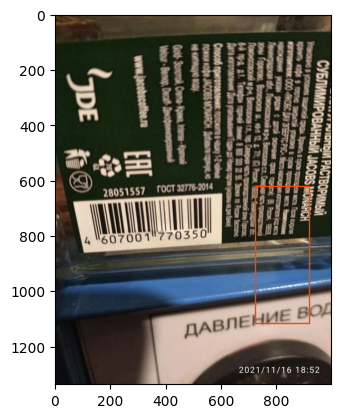

In [169]:
# idx=16
# idx = 72
idx = 78
xmin,xmax=[int(x) for x in sorted(pred[0]["boxes"][idx,[0,2]].tolist())]
ymin,ymax=[int(x) for x in sorted(pred[0]["boxes"][idx,[1,3]].tolist())]

pol = Polygon(
    [
        (xmin,ymin),
        (xmin,ymax),
        (xmax,ymax),
        (xmax,ymin),
        (xmin,ymin)
    ],
    ec='orangered',
    fc='none'
)
plt.imshow(img)
plt.gca().add_patch(pol)
plt.show()

In [162]:
idx

73

In [ ]:
metric.compute()

In [ ]:
targets

In [38]:
[p["boxes"].shape for p in pred]

[{'boxes': tensor([], size=(0, 4)),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([])},
 {'boxes': tensor([], size=(0, 4)),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([])}]

In [ ]:
type(model)
#(images,targets)

In [ ]:
[x for x in pred if x["scores"].nelement()]

In [ ]:
thv.models.detection.faster_rcnn.__file__

In [ ]:
metric.compute()

In [ ]:
thv.ops.box_iou?

In [ ]:
targets

In [ ]:
model(images, targets)

In [ ]:
_=model.eval()

In [ ]:
model(images)

In [ ]:
thv.ops.box_iou(
    [x for x in pred if x["scores"].nelement()],
    targets
)

In [ ]:
b.keys()

In [ ]:
b["label"]

In [ ]:
b["boxes"] = b["label"]

In [ ]:
import torch as th

In [ ]:
th.stack(b["boxes"], axis=1)

In [ ]:
b["boxes"]

In [ ]:
targets = []
for bbox in b["label"]:
    targets.append(
        {
            "boxes": 
        }
    )

In [ ]:
th2pil = thv.transforms.ToPILImage()

In [ ]:
th2pil(b["image"][0].tra)

In [ ]:
modelb["image"][:1], [{"boxes":th.stack(b["boxes"], axis=1)}])